In [1]:
# Python Free Fermion Large Scale Simulation Platform (PyFerm) Demos
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
# My PyFerm modules:
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import math

# Example 1: Model a continuous Hamiltonian #

In this example, we first show how to use the free Fermion formalism to map a continuous Hamiltonian (in terms of Pauli matrices) to the Fermionic creators and annihilators. Then we simulate the time evolution using the free Fermion simulation. 

We measure on all qubits in the Z basis after the evolution and compare the measurement probabilities with the exact diagonalization simulation result.

The mapping between Fermionic and Pauli Hamiltonian evolutions is based on the Jordan-Wigner transformation:

$\begin{align} \label{JW}
&a_j^{\dagger}:=\left(\prod_{k=1}^{j-1} Z_k\right)\left(\frac{X_j-i Y_j}{2}\right) \\
&a_j:=\left(\prod_{k=1}^{j-1} Z_k\right)\left(\frac{X_j+i Y_j}{2}\right),
\end{align}$

where the "multiplication" operations are tensor products. The creation and annihilation operators follow the anti-commuting rules:

$\left\{a_{i}, a_{j}\right\} \equiv a_{i} a_{j}+a_{j} a_{i}=0, \quad\left\{a_{i}^{\dagger}, a_{j}^{\dagger}\right\}=0, \quad\left\{a_{i}, a_{j}^{\dagger}\right\}=\delta_{i j} I$

In this example we look at a Fermion-preserving Hamiltonian on two fermion modes $i$ and $j$, written as (assuming $i<j$):

$\begin{equation}
\mathcal{H}_{Fermi}=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+b_{i j} a_i^{\dagger} a_j+b_{i j}^* a_j^{\dagger} a_i.
\end{equation}$

Because $H$ is hermitian, $a_{ii}, a_{jj}$ are real. We express $b_{ij}$ as $c+di$, where $c$ and $d$ are real continuous numbers.

In the most general case, $H$ corresponds to a Hamiltonian (in Pauli matrix form) which describes the interaction between qubits $i$ and $j$:

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{Pauli} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In this example we first simulate the Z-basis measurement probabilities on the final state $|\psi_{f} \rangle = e^{-i\mathcal{H} t} |\psi_0 \rangle$ after the time evolution of $e^{-i\mathcal{H} t}$ on an input product state $|\psi_0 \rangle$. This simulation is computed in <b>polynomial<b> time of the number of qubits $N$.

We then compare the measurement probabilities with the exact diagonalization calculation, keeping track of the full state. This scales <b>exponential<b> time of the number of qubits $N$.

In [3]:
# First we create a simulation object, from the Fermion "Network" class.

N = 10 # 10 qubits
conn_list = [[1, 6]] # We consider the Hamiltonian interaction between qubit 1 and 6 (zero indexed)
evolution = Network(conn_list, N) # Create an evolution simulation, calling my PyFerm module
x_input = torch.tensor([[1,0]*(N//2)]) # The input state is the 1010101... single basis state
print('Connectivity: ', conn_list)
print('Input state: ', x_input)

debug self.L 1
Connectivity:  [[1, 6]]
Input state:  tensor([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]])


In [15]:
# Randomly sample the real a, b, c, d parameters, where a = b_ii, b = b_jj, c+di = b_ij
params_abcd = torch.tensor(math.pi) * torch.rand((N, 4)) # Randomly initialize parameters
t = 1.5 # For how long do we evolve the state
evolution.manual_set_params(t*params_abcd) # Set the evolution parameters

debug self.V_l_module_list len 1
debug self.V_l_module_list.parameters() <generator object Module.parameters at 0x7fa514add430>
param Parameter containing:
tensor(2.9893, requires_grad=True)
param Parameter containing:
tensor(5.4397, requires_grad=True)
param Parameter containing:
tensor(5.0763, requires_grad=True)
param Parameter containing:
tensor(3.1754, requires_grad=True)


In [16]:
# A quick example to calculate the probability density of observing bit string y
y = torch.tensor([[1,0,1,0,1,0,1,0,1,0]]) # What is the probability of observing 111000 after evolving 101010?
prob = (evolution.forward(y, x_input))**2 # calculates P(y|x), the probability of observing y given input x
print('P(y|x)=', prob)

P(y|x)= tensor([-0.5113+0.6305j], grad_fn=<PowBackward0>)


In [17]:
# Now calculate the probability of P(y|x_input) for all possible y bitstrings:
basis_m_n = torch.tensor(binary_basis(geometry=(N,))) # shape is number of y bitstrings by 2^N
probs = np.zeros(2**N)
# The evolution Network object can handle batch processing of p(y_batch|x_input_batch)
y_batch = basis_m_n
x_batch = x_input.repeat(y_batch.shape[0], 1) # shape is number of y bitstrings by 2^N

# This is a mask tensor that tells the network which qubits to measure at the end
# For example, [1111111111] indicates that we meausure on all 10 qubits in the end
# [1111100000] indicates that we measure on the first 5 qubits in the end
measure_mask_batch = (torch.tensor([[1]*N])).repeat(y_batch.shape[0], 1) # shape is number of y bitstrings by N

ts = time.time()
# The returned measurement probabilities are torch tensors, don't forget to detach and convert to numpy
probs_batch = evolution.forward_partial_observation(y_batch, x_batch, measure_mask_batch).detach().numpy()
tf = time.time()
print('time used', tf-ts)

time used 0.43309593200683594


/Users/pengyuanzhai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'prob')

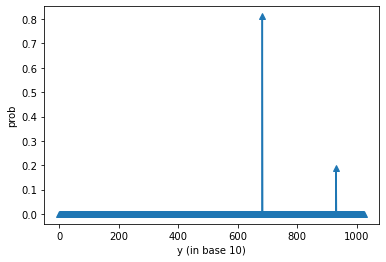

In [18]:
# Plot the measurement probabilities:
plt.plot(probs_batch, '^-')
plt.xlabel('y (in base 10)')
plt.ylabel('prob')

# Compare with Exact Diagnalization

Does the Fermion simulation return the correct probabilities? Let us compare with the measurement probabilities with the exact diagonalization.

In [19]:
import qiskit # Use qiskit to conveniently convert bit strings to statevectors

x_string = '10'*int(N/2)+'1' if N%2==1 else '10'*int(N/2)
init_state_numpy = qiskit.quantum_info.Statevector.from_label(x_string).data
print('input x string', x_string)
ts = time.time()

# Initialize the exact e^{-iHt} evolution matrix
exp_iH_exact = np.eye(2**N)

conn = conn_list[0]
a, b, c, d = params_abcd.detach().numpy()[0]
H_exact = initialize_sparse(N, conn[0], conn[1], a, b, c, d)
exp_iH_exact = (scipy.linalg.expm(-t*1.0j*H_exact))@exp_iH_exact

state_exact = np.matmul(exp_iH_exact, init_state_numpy[:,None])
probs_exact = (np.abs(state_exact)**2).squeeze()
tf = time.time()

print('time used', tf-ts)

input x string 1010101010
debug a, b, c, d) (1.1209452, 0.3134517, 2.5827215, 2.8778558)
H_z   (0, 0)	-0.7171984612941742
  (1, 1)	-0.7171984612941742
  (2, 2)	-0.7171984612941742
  (3, 3)	-0.7171984612941742
  (4, 4)	-0.7171984612941742
  (5, 5)	-0.7171984612941742
  (6, 6)	-0.7171984612941742
  (7, 7)	-0.7171984612941742
  (8, 8)	-0.40374675393104553
  (9, 9)	-0.40374675393104553
  (10, 10)	-0.40374675393104553
  (11, 11)	-0.40374675393104553
  (12, 12)	-0.40374675393104553
  (13, 13)	-0.40374675393104553
  (14, 14)	-0.40374675393104553
  (15, 15)	-0.40374675393104553
  (16, 16)	-0.7171984612941742
  (17, 17)	-0.7171984612941742
  (18, 18)	-0.7171984612941742
  (19, 19)	-0.7171984612941742
  (20, 20)	-0.7171984612941742
  (21, 21)	-0.7171984612941742
  (22, 22)	-0.7171984612941742
  (23, 23)	-0.7171984612941742
  (24, 24)	-0.40374675393104553
  :	:
  (999, 999)	0.40374675393104553
  (1000, 1000)	0.7171984612941742
  (1001, 1001)	0.7171984612941742
  (1002, 1002)	0.7171984612941742
  

time used 1.0680558681488037


Total variation between Fermion and Exact simulations 1.2297029346327473e-06


/Users/pengyuanzhai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


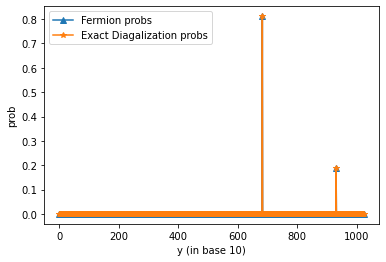

In [21]:
# Calculate the sum of absolute differences in density values
tv = np.abs(probs_batch-probs_exact).sum()
print('Total variation between Fermion and Exact simulations', tv)
# Plot the probabilities from exact diagonalization to fermion simulation. Yay they match!
plt.plot(probs_batch, '^-')
plt.plot(probs_exact, '*-')
plt.xlabel('y (in base 10)')
plt.ylabel('prob')
plt.legend(['Fermion probs', 'Exact Diagalization probs'])